# Process optimization with PharmaPy

In this notebook, we will learn how to use PharmaPy to perform process optimization. For this purpose, a four-unit process flowsheet containing continuous, semi-continuous and batch units will be used.

The process starts with a chemical synthesis step in a continuous PFR (`R01`), which yields a desired API `C` and a subproduct `D`. The material from `R01` is contiuously collected `HOLD01` and then sent to a batch crystallizer `CR01`, where cooling crystallization takes place. Finally, the slurry is taken to a batch filter `F01`, where a cake of solid material is recovered.

![pfd_process](img/pfd_flowsheet.png)

In [1]:
# Standard Imports
import numpy as np
from copy import deepcopy

# PharmaPy imports
from PharmaPy.Reactors import PlugFlowReactor
from PharmaPy.Crystallizers import BatchCryst
from PharmaPy.SolidLiquidSep import Filter
from PharmaPy.Containers import DynamicCollector

from PharmaPy.Streams import LiquidStream
from PharmaPy.Phases import LiquidPhase, SolidPhase
from PharmaPy.Kinetics import RxnKinetics, CrystKinetics

from PharmaPy.Utilities import CoolingWater
from PharmaPy.Interpolation import PiecewiseLagrange
from PharmaPy.ProcessControl import DynamicInput

from PharmaPy.SimExec import SimulationExec

Could not find GLIMDA.


In the first part of this tutorial, a simulation will be set up by specifying the participating equipment and their connectivity by using the `graph` variable below. Then, a callback function that encapsulates the simulation will be put together, which can be repetedly called by an optimizer.

A simulation object `flst` is created using the `SimulationExec` class of PharmaPy, similar to what we did in the parameter estimation section. This time, the different unit operations specified in the `graph` variable are aggregated to the blank simulation. Remember that the documentation of any PharmaPy class or method can be retrieved by simultaneously pressing the `Shift` and `Tab` keys.

In [2]:
# Reactor definition
# Physical properties of species
path_phys = '../data/compound_database.json'

# Initially define a flowsheet object for the simulation executive
# This object will allow us to simulate the entire flowsheet.

graph = 'R01 --> HOLD01 --> CR01 --> F01'
flst = SimulationExec(path_phys, flowsheet=graph)

# Specifying a stoichiometric matrix
rxns = ['A + B --> C', 'A + C --> D']

# Kinetics values; assuming deltaH values are 0.
k_vals = np.array([2.654e4, 5.3e2])  # Pre-exponential factor
ea_vals = np.array([4.0e4, 3.0e4])  # Activation Energies

# Use the imported RxnKinetics class to create a RxnKinetics instance
kinetics = RxnKinetics(path=path_phys, rxn_list=rxns, k_params=k_vals, ea_params=ea_vals)

##################
vol_liq = 0.010
tau_R01 = 1800

vol_flow = vol_liq / tau_R01  # m**3 / s
w_init = np.array([0, 0, 0, 0, 1])
liquid_init = LiquidPhase(path_phys, 313.15, mass_frac=w_init, vol=vol_liq)

# Cooling water
temp_set_R01 = 313.15
cw = CoolingWater(mass_flow=0.1, temp_in=temp_set_R01)  # mass flow in kg/s

# ---------- Inlet streams
# Reactor
c_in = np.array([0.33, 0.33, 0, 0, 0])

temp_in = 40 + 273.15  # K

liquid_in = LiquidStream(path_phys, temp_in, mole_conc=c_in, vol_flow=vol_flow, name_solv='solvent')

diam_in = 1 / 2 * 0.0254  # 1/2 inch in m
flst.R01 = PlugFlowReactor(diam_in=diam_in, num_discr=50, isothermal=False)
flst.R01.Utility = cw

flst.R01.Kinetics = kinetics
flst.R01.Inlet = liquid_in
flst.R01.Phases = (liquid_init,)
flst.R01.Utility = cw

runtime_reactor = 3600 * 2

# With a continuous unit follow by a batch unit, we need a collection unit,
# a holding tank, to intermediately follow the the continuous unit.
flst.HOLD01 = DynamicCollector()

In [3]:
# Defining the crystallizer
prim = (3e8, 0, 3)  # kP in #/m3/s
sec = (4.46e10, 0, 2, 1e-5) # kS in #/m3/s
growth = (5, 0, 1.32)  # kG in um/s
dissol = (1, 0, 1) # kD in um/s

# 0.2269 - 1.88e-3 * 323.15 + 3.89e-6 * 323.15 ** 2
solub_cts = np.array([2.269e2, -1.88e0, 3.89e-3])

x_gr = np.geomspace(1, 1500, num=35)
distrib_init = np.zeros_like(x_gr)

solid_cry = SolidPhase(path_phys, x_distrib=x_gr, distrib=distrib_init,
                   mass_frac=[0, 0, 1, 0, 0])

# Piecewise temperature profile definition
temp_program = np.array([[313.15, 303.15],
                         [303.15, 295.15],
                         [295.15, 278.15],
                        ], dtype=np.float64)

# Initialize lagrange polynomial control object
runtime_cryst = runtime_reactor * 2.0
lagrange_fn = PiecewiseLagrange(runtime_cryst, temp_program)

# Defining the crystallizer with desired species 'C'
flst.CR01 = BatchCryst(target_comp='C', method='1D-FVM', scale=1e-9, controls={'temp': lagrange_fn.evaluate_poly})

flst.CR01.Kinetics = CrystKinetics(solub_cts, nucl_prim=prim, nucl_sec=sec, growth=growth, dissolution=dissol)
flst.CR01.Utility = CoolingWater(mass_flow=1, temp_in=283.15)
flst.CR01.Phases = solid_cry

In [4]:
# Defining the filter.
# Filter
alpha = 1e11
Rm = 1e10

filt_area = 200  # cm**2
diam = np.sqrt(4/np.pi * filt_area) / 100  # m

flst.F01 = Filter(diam, alpha, Rm)

In [5]:
# Gluing everything together and running the flowsheet

# runargs for the flowsheet
runargs_R01 = {'runtime': runtime_reactor}
sundials = {'maxh': 60}
runargs_hold = {'runtime': runtime_reactor}
runargs_CR01 = {'runtime': runtime_cryst, 'sundials_opts': sundials}
runargs_F01 = {'runtime': None}

# ---------- Running simulation
run_kwargs = {'R01': runargs_R01,
              'HOLD01': runargs_hold,
              'CR01': runargs_CR01,
              'F01': runargs_F01
              }

flst.SolveFlowsheet(kwargs_run=run_kwargs)


------------------------------
Running R01
------------------------------

Final Run Statistics: --- 

 Number of steps                                 : 172
 Number of function evaluations                  : 220
 Number of Jacobian*vector evaluations           : 445
 Number of function eval. due to Jacobian eval.  : 220
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 217
 Number of nonlinear convergence failures        : 1

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : SPGMR
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 7200.0 seconds.
Elapsed simulation time: 0.5636364 seconds.

Done!


------------------------------
Running HOLD01
------------------------------

Final Run Statistics: --- 

 Number of steps                                 : 62
 Nu

Mean crystal size:  46.26220772243934



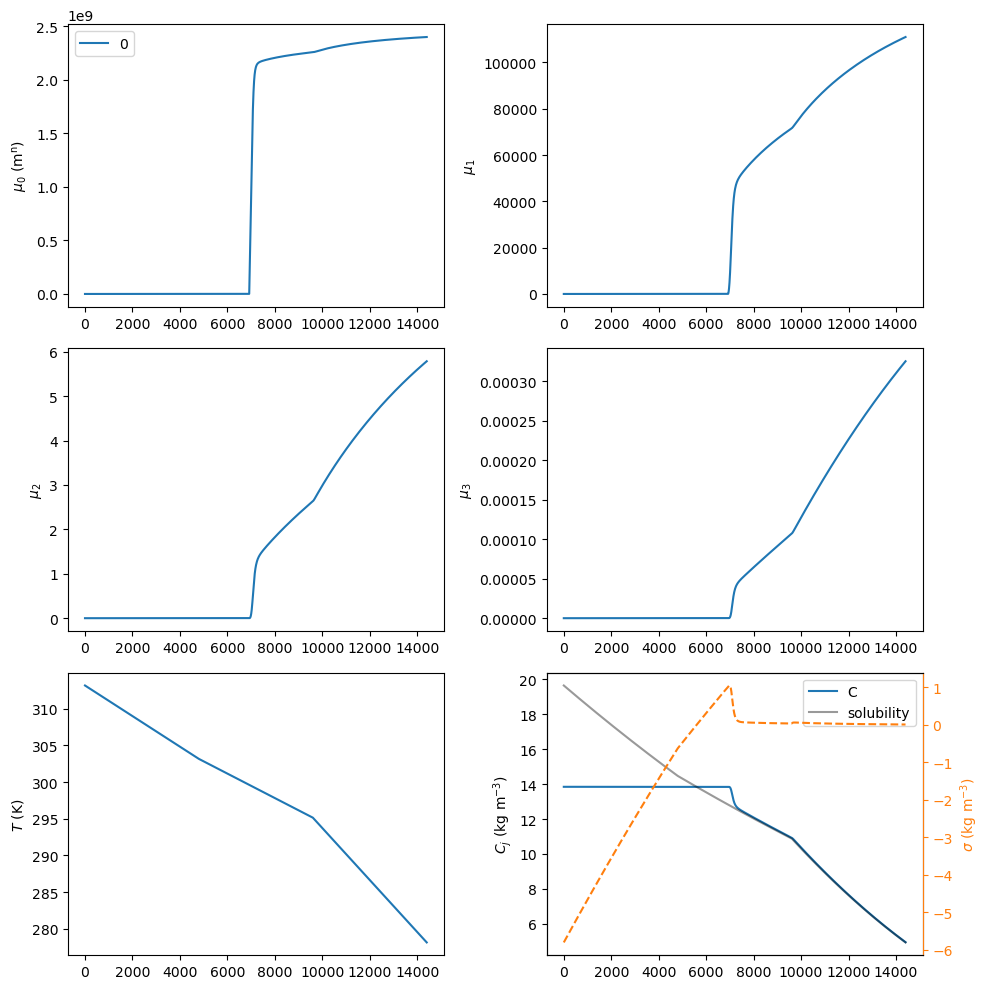

In [6]:
flst.CR01.plot_profiles(figsize=(10, 10))
moments = flst.CR01.result.mu_n[-1]

mean_size = moments[1] / moments[0] * 1e6
print('Mean crystal size: ', mean_size, end='\n\n')

The complete crystal size distribution (CSD) can be plotted for different times using the `plot_csd` method of the crystallizer `CR01` object. As seen in the bottom right panel above, supersaturation $\sigma$ starts being positive around 3000 s, so that will be used as the initial time to plot the CSD. It is worth mentioning that PharmaPy will try to find the closest time to plot from the timegrid resulting from numerical integration

(<Figure size 500x400 with 1 Axes>,
 <AxesSubplot: xlabel='$x$ ($\\mathregular{\\mu m}$)', ylabel='$f$ ($\\mathregular{\\# \\ um^{-1}}$)'>)

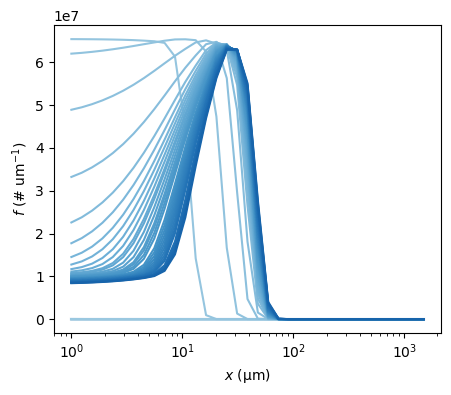

In [7]:
flst.CR01.plot_csd(times=np.linspace(6000, 9000), figsize=(5, 4))

(<Figure size 1000x500 with 2 Axes>,
 array([<AxesSubplot: ylabel='mass liquid (kg)'>,
        <AxesSubplot: xlabel='time (s)', ylabel='mass cake (kg)'>],
       dtype=object))

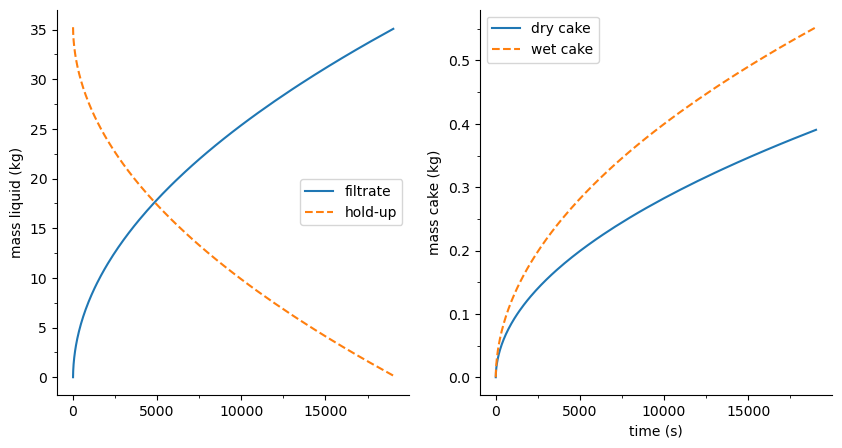

In [8]:
flst.F01.plot_profiles(figsize=(10, 5))

Simulation objects also have `result` attribute (an object itself). When printed, it provides an overview of the simulation 

In [9]:
print(flst.result)
print(flst.R01.result)

---------------------
Welcome to PharmaPy
---------------------

Flowsheet structure:
R01 --> HOLD01 --> CR01 --> F01

---------------------------------------------------------------------
Unit operation   Diff eqns   Alg eqns   Model type   PharmaPy type       
---------------------------------------------------------------------
R01              300         0          ODE          PlugFlowReactor     
HOLD01           7           0          ODE          DynamicCollector    
CR01             41          0          ODE          BatchCryst          
F01              2           0          ODE          Filter              
---------------------------------------------------------------------
------------------------
PharmaPy result object
------------------------

Fields shown in the tables below can be accessed as result.<field>, e.g. result.mole_conc 

------------------------------------------------
states      dim   units     index                  
----------------------------------

## Process design

Now, flowsheet optimization will be explored. In the current exercise, we aim to scale up a process to produce 5 kg/day of the API of interest. Additonally, we are interested in the crystal product having a mean size of at least 40 microns. For this purpose, an optimization problem can be formulated, where raw material consumption ($J$) is to be minimized

$$ \min_{x} J(x) $$

subject to the PharmaPy model
$$ \begin{align*}
       \frac{dy}{dt} &= f_1(x, y, z, t, \theta) \\
       0             &= f_2(x, y, z, t, \theta)
   \end{align*}
$$

and the constraints:

$$ \begin{align*}
       40            & \leq \frac{\mu_1}{\mu_0}\Bigr\rvert_{t_f} \cdot 10^6 && \text{(Size constraint)} \\
       5             & \leq N_{batches} \cdot M_{API, F01} && \text{(Daily production constraint)} \\
       T_{k + 1}     & \leq T_k \ \text{for all } k \in \{1, 2\} && \text{(Monotonically decreasing cooling profile)} \\
       x_{lb}        & \leq x \leq x_{ub} && \text{(Bound constraints)}
   \end{align*}
$$

with $M_{API}$ the mass of filtration cake obtained after the filtration step in F01.

Decision variables $x$ will be:

| Unit operation | Variable ($x$) | Units |
| -------------- | -------------- | ----- |
| R01            | $\tau_{R01}$   | s     |
| CR01           | $T_{k, CR01}$  | K     |
|                | $t_{CR01}$     | s     |
| F01            | $\Delta P_{F01}$     | Pa     |

and three intermediate temperatures will be used as decision variables for CR01 ($k = [1, 2, 3]$). This gives a total of 6 decision variables. Number of batches a day $N_{batches}$ can be calculated as:

$$
N_{batches} = \frac{24 \times 3600}{t_{cycle}}
$$

where cycle time $t_{cycle}$ is the maximum time among the processsing times for the individual unit operations, i.e. $t_{cycle} = \max{(t_{R01}, t_{CR01}, t_{F01})}$. For simplicity, it will be assumed that R01 will flow material to HOLD01 during 2 h before transfering material to CR01, i.e. $t_{R01} =$ 2h.

As done before, an unconstrained version of the optimization problem is formulated through a penalty method:

$$
\min_x J(x) + \sum_{i \in \mathcal{I}} [ \max(0, \alpha_i \cdot g_i) ]^2, \ \mathcal{I} = \{1, \ldots, n_{constraints} \}
$$

In [10]:
def get_costs(sim, raw_costs):
    raw_mat = sim.GetRawMaterials()
    
    # print(raw_mat)
    raw_mat = raw_mat.filter(regex='mass_').sum()

    raw_cost = raw_mat * raw_costs

    return raw_cost.to_dict()

def get_constraints(sim, temp_k, n_batches):
    mu = sim.CR01.result.mu_n[-1]
    mass_api = sim.F01.result.mass_cake_dry[-1]
    
    mass_total = mass_api * n_batches
    
    # print('mass_api_total: ', mass_total, end='\n\n')
    
    temp_constr = temp_k[1:] - temp_k[:-1]
    
    constraints = [40 - mu[1]/mu[0]*1e6, 5 - mass_total] + temp_constr.tolist()  # concatenate lists
    
    return constraints


def make_non_verbose(runargs):
    for key in runargs:
        runargs[key]['verbose'] = False
        
    return runargs

def callback_opt(x, simulate=False, raw_material_cost=None, return_augm=True, weights=None):
    
    if weights is None:
        weights = np.ones(4)  # four constraints (one for size, one for production and two for temperature)
    else:
        weights = np.asarray(weights)
            
    
    tau_R01 = x[0]
    temp_CR01 = x[1:4]
    time_CR01 = x[4]
    deltaP = x[-1]
    
    # Create simulation
    path_phys = '../data/compound_database.json'

    # Initially define a flowsheet object for the simulation executive
    # This object will allow us to simulate the entire flowsheet.

    graph = 'R01 --> HOLD01 --> CR01 --> F01'
    flst = SimulationExec(path_phys, flowsheet=graph)

    # Specifying a stoichiometric matrix
    rxns = ['A + B --> C', 'A + C --> D']

    # Kinetics values; assuming deltaH values are 0.
    k_vals = np.array([2.654e4, 5.3e2])  # Pre-exponential factor
    ea_vals = np.array([4.0e4, 3.0e4])  # Activation Energies

    # Use the imported RxnKinetics class to create a RxnKinetics instance
    kinetics = RxnKinetics(path=path_phys, rxn_list=rxns, k_params=k_vals, ea_params=ea_vals)

    ##################
    vol_liq = 0.010  # m**3

    vol_flow = vol_liq / tau_R01  # m**3 / s
    x_init = np.array([0, 0, 0, 0, 1])  # only solvent
    temp_init = 298.15  # K
    liquid_init = LiquidPhase(path_phys, temp_init, mole_frac=x_init, vol=vol_liq)

    # Cooling water
    temp_R01 = 313.15  # K
    cw = CoolingWater(mass_flow=0.1, temp_in=temp_R01)  # mass flow in kg/s

    # ---------- Inlet streams
    # Reactor
    c_in = np.array([0.33, 0.33, 0, 0, 0])

    temp_in = 20 + 273.15  # K

    liquid_in = LiquidStream(path_phys, temp_in, mole_conc=c_in, vol_flow=vol_flow, name_solv='solvent')

    diam_in = 1 / 2 * 0.0254  # 1/2 inch in m
    flst.R01 = PlugFlowReactor(diam_in=diam_in, num_discr=50, isothermal=False)
    flst.R01.Utility = cw

    flst.R01.Kinetics = kinetics
    flst.R01.Inlet = liquid_in
    flst.R01.Phases = (liquid_init,)
    flst.R01.Utility = cw

    time_R01 = 2 * 3600  # s

    # Holding tank
    flst.HOLD01 = DynamicCollector()
    
    # Crystallizer
    prim = (3e8, 0, 3)  # kP in #/m3/s
    sec = (4.46e10, 0, 2, 1e-5) # kS in #/m3/s
    growth = (5, 0, 1.32)  # kG in um/s
    dissol = (1, 0, 1) # kD in um/s

    # 0.2269 - 1.88e-3 * 323.15 + 3.89e-6 * 323.15 ** 2
    solub_cts = np.array([2.269e2, -1.88e0, 3.89e-3])

    x_gr = np.geomspace(1, 1500, num=35)
    distrib_init = np.zeros_like(x_gr)

    solid_cry = SolidPhase(path_phys, x_distrib=x_gr, distrib=distrib_init,
                       mass_frac=[0, 0, 1, 0, 0])

    # Piecewise temperature profile definition
    temp_program = np.array([[313.15, temp_CR01[0]],
                             [temp_CR01[0], temp_CR01[1]],
                             [temp_CR01[1], temp_CR01[2]]], dtype=np.float64)

    # Initialize lagrange polynomial control object
    lagrange_fn = PiecewiseLagrange(time_CR01, temp_program)

    # Defining the crystallizer with desired species 'C'
    flst.CR01 = BatchCryst(target_comp='C', method='1D-FVM', scale=1e-9,
                           controls={'temp': lagrange_fn.evaluate_poly})

    flst.CR01.Kinetics = CrystKinetics(solub_cts, nucl_prim=prim, nucl_sec=sec, growth=growth, dissolution=dissol)
    flst.CR01.Phases = solid_cry
    
    # Filter
    alpha = 1e11
    Rm = 1e10

    filt_area = 200  # cm**2
    diam = np.sqrt(4/np.pi * filt_area) / 100  # m

    flst.F01 = Filter(diam, alpha, Rm)
    
    # runargs for the flowsheet
    runargs_R01 = {'runtime': time_R01}
    sundials = {'maxh': 60}
    runargs_hold = {'runtime': time_R01}
    runargs_CR01 = {'runtime': time_CR01, 'sundials_opts': sundials}
    runargs_F01 = {'runtime': None, 'deltaP': deltaP}

    # ---------- Running simulation
    run_kwargs = {'R01': runargs_R01,
                  'HOLD01': runargs_hold,
                  'CR01': runargs_CR01,
                  'F01': runargs_F01
                  }
    
    run_kwargs = make_non_verbose(run_kwargs)
    if simulate:
        flst.SolveFlowsheet(kwargs_run=run_kwargs, verbose=False)
        return flst
    
    else:
        # Simulate
        flst.SolveFlowsheet(kwargs_run=run_kwargs, verbose=False)
        
        # Calculate objective + constraints
        t_cycle = max([flst.R01.result.time[-1], flst.CR01.result.time[-1], flst.F01.result.time[-1]])
        n_batches = 24 * 3600 / t_cycle
        
        costs = get_costs(flst, raw_material_cost)  # J(x)
        constraints = get_constraints(flst, temp_CR01, n_batches)  # g_i(x)
        
        if return_augm:
            penalties = np.maximum(0, weights * constraints)
            total_cost = sum(list(costs.values())) * n_batches
            
            augmented_obj = total_cost + sum(penalties**2)
            # print(augmented_obj)
            return augmented_obj
        else:
            out = {'cost/batch': costs, 'size_constr': constraints[0], 'production_constr': constraints[1],
                  'temperature_constr': constraints[2:]}
            
            return out

def print_di(di):
    for key in di:
        print(key + ':', di[key], end='\n\n')

Let's run in simulation model to make sure everything is working internally

(<Figure size 700x350 with 2 Axes>,
 array([<AxesSubplot: ylabel='mass liquid (kg)'>,
        <AxesSubplot: xlabel='time (s)', ylabel='mass cake (kg)'>],
       dtype=object))

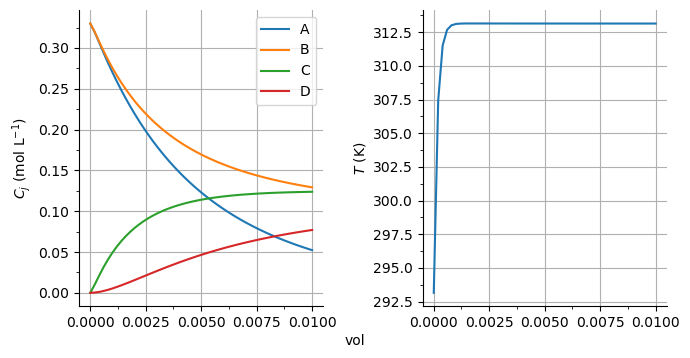

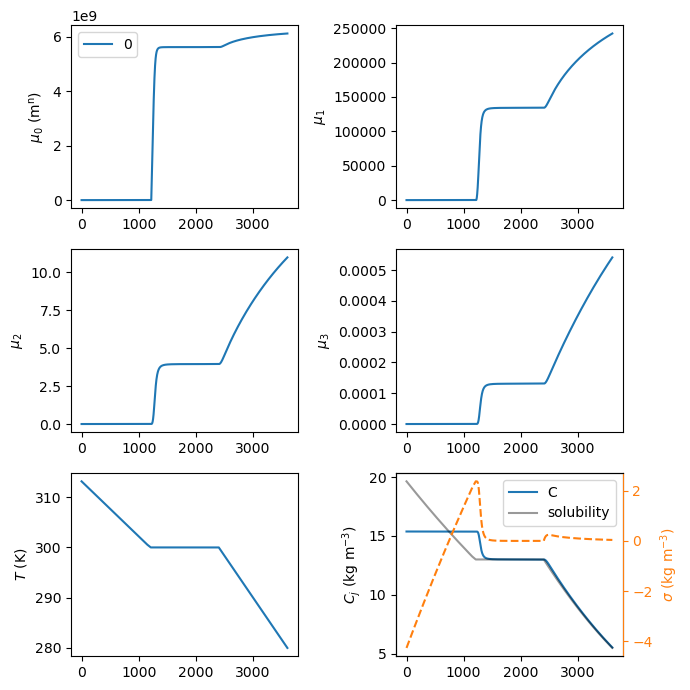

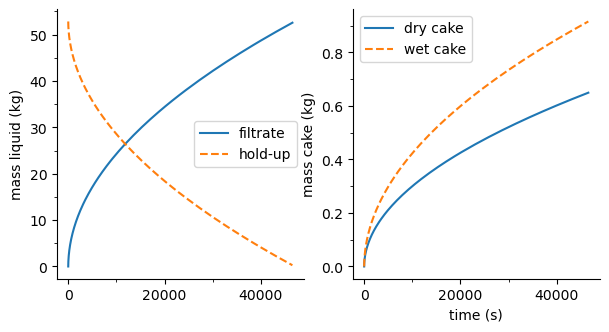

In [11]:
x_init = np.array([1200,  # tau_R01
          300,  # T_{1,CR01}
          300,  # T_{2,CR01}
          280,  # T_{3,CR01}
          3600, # t_{CR01}
          101325]  # deltaP_{F01}
                 )

sim = callback_opt(x_init, simulate=True)

# Let's plot some dynamics and see what the results look like
sim.R01.plot_profiles(times=[sim.R01.result.time[-1]], pick_comp=('A', 'B', 'C', 'D'), figsize=(7, 3.5))
sim.CR01.plot_profiles(figsize=(7, 7))
sim.F01.plot_profiles(figsize=(7, 3.5))

As a second step, let's call the objective function and see if it computes the costs correctly:

In [12]:
raw_costs = np.genfromtxt('../data/raw_material_cost.csv', delimiter=',', skip_header=1)[:, 1]

weights = [100, 100, 1, 1]  # These can be changed to emphasize on one constraint over the other

di_callback = callback_opt(x_init, simulate=False, raw_material_cost=raw_costs, weights=weights, return_augm=False)
print_di(di_callback)

augmented = callback_opt(x_init, raw_material_cost=raw_costs, weights=weights)
print('augmented_objective:', augmented, end='\n\n')

cost/batch: {'mass_A': 19.8, 'mass_B': 11.879999999999999, 'mass_C': 0.0, 'mass_D': 0.0, 'mass_solvent': 119.37392429236701}

size_constr: 0.44473731909014447

production_constr: 3.7957609916886987

temperature_constr: [0, -20]

augmented_objective: 146336.1644267248



Now, let's try optimization. For this purpose, bounds on the studied decision variables will be passed, in order to make the optimization well behaved and physically coherent.

In [13]:
from scipy.optimize import minimize
import time

optimopts = {'maxfev': 10}

temp_bounds = (273, 310)
bounds_di = {'tau_R01': (10*60, 2*3600), 'temp_CR01_1': temp_bounds, 'temp_CR01_2': temp_bounds, 'temp_CR01_3': temp_bounds,
             't_CR01': (10*60, 4*3600), 'deltaP': (101325, 101325*5)}

bounds = list(bounds_di.values())

args_callback = (False, raw_costs, True, weights)  # Anything after the x in the callback_opt argument sequence

tic = time.time()
result = minimize(callback_opt, x0=x_init, method='Nelder-Mead', args=args_callback, options=optimopts, bounds=bounds)
toc = time.time()

In [14]:
print('Elapsed optimization time: %.1f seconds' % (toc - tic), end='\n\n')

print('Initial decision variables:')
print(x_init, end='\n\n')

print('SciPy result:')
print(result, end='\n\n')

di_optim = callback_opt(result.x, raw_material_cost=raw_costs, return_augm=False)

for key in di_optim:
    print(key, di_optim[key], end='\n\n')

Elapsed optimization time: 14.5 seconds

Initial decision variables:
[  1200    300    300    280   3600 101325]

SciPy result:
 final_simplex: (array([[  1260.        ,    300.        ,    300.        ,
           280.        ,   3600.        , 101325.        ],
       [  1220.        ,    303.33333333,    303.33333333,
           273.        ,   3660.        , 103013.75      ],
       [  1200.        ,    300.        ,    300.        ,
           280.        ,   3600.        , 106391.25      ],
       [  1206.66666667,    301.11111111,    305.27777778,
           279.41666667,   3620.        , 101887.91666667],
       [  1200.        ,    300.        ,    300.        ,
           280.        ,   3780.        , 101325.        ],
       [  1200.        ,    310.        ,    300.        ,
           280.        ,   3600.        , 101325.        ],
       [  1200.        ,    300.        ,    300.        ,
           280.        ,   3600.        , 101325.        ]]), array([140223.130201

As seen above, somee of the constraints are still positive after 10 iterations (infeasible). The optimization can be restarted with the value of $x$ contained in the optimization `result` object from SciPy. Also, the final simplex can be passed to speed up the second optimization round

In [21]:
x_last = result.x
simplex = result.final_simplex[0]

optimopts = {'maxfev': 400, 'initial_simplex': simplex}

tic = time.time()
result_two = minimize(callback_opt, x0=x_last, method='Nelder-Mead', options=optimopts, args=args_callback, bounds=bounds)
toc = time.time()

In [22]:
print('Elapsed optimization time: %.1f seconds' % (toc - tic), end='\n\n')

print(result_two, end='\n\n')

di_optim_two = callback_opt(result_two.x, return_augm=False, raw_material_cost=raw_costs)
print_di(di_optim_two)

Elapsed optimization time: 543.1 seconds

 final_simplex: (array([[1.81817468e+03, 3.04512168e+02, 2.98743703e+02, 2.74987165e+02,
        3.72843633e+03, 2.88148112e+05],
       [1.81815768e+03, 3.04511872e+02, 2.98744043e+02, 2.74987872e+02,
        3.72847233e+03, 2.88145125e+05],
       [1.81816246e+03, 3.04511954e+02, 2.98743952e+02, 2.74987672e+02,
        3.72846226e+03, 2.88145947e+05],
       [1.81816363e+03, 3.04511972e+02, 2.98743926e+02, 2.74987626e+02,
        3.72845974e+03, 2.88146147e+05],
       [1.81816384e+03, 3.04511962e+02, 2.98743934e+02, 2.74987619e+02,
        3.72845926e+03, 2.88146101e+05],
       [1.81816472e+03, 3.04511973e+02, 2.98743922e+02, 2.74987582e+02,
        3.72845741e+03, 2.88146223e+05],
       [1.81815620e+03, 3.04511856e+02, 2.98744070e+02, 2.74987927e+02,
        3.72847539e+03, 2.88144908e+05]]), array([  1268.77938395,   1268.78925842, 100785.26476248, 100787.46204912,
       100797.20005326, 100838.42071573, 130772.79570793]))
           fu

Let's compare initial and converged $x$ values, as well as constraint values

In [23]:
import pandas as pd

bounds_di = {'tau_R01': (10*60, 2*3600), 'temp_CR01_1': temp_bounds, 'temp_CR01_2': temp_bounds, 'temp_CR01_3': temp_bounds,
             't_CR01': (10*60, 4*3600), 'deltaP': (101325, 101325*5)}
x_summary = pd.DataFrame(np.column_stack((x_init, result_two.x)),
                         index=list(bounds_di.keys()), columns=('initial', 'converged'))

print(x_summary)

constr_initial = {key: val for key, val in di_callback.items() if 'constr' in key}
constr_convgd = {key: val for key, val in di_optim_two.items() if 'constr' in key}

constr_summary = pd.DataFrame((constr_initial, constr_convgd), index=('initial', 'final'))
print(constr_summary.T)


              initial      converged
tau_R01        1200.0    1818.174682
temp_CR01_1     300.0     304.512168
temp_CR01_2     300.0     298.743703
temp_CR01_3     280.0     274.987165
t_CR01         3600.0    3728.436331
deltaP       101325.0  288148.111920
                     initial                                      final
size_constr         0.444737                                  -2.839212
production_constr   3.795761                                  -0.000375
temperature_constr  [0, -20]  [-5.768464416248889, -23.756538637020128]


We can plot some results to see the current status of the converged solution

In [24]:
sim_opt = callback_opt(result_two.x, simulate=True)
sim_opt.CR01.result

------------------------
PharmaPy result object
------------------------

Fields shown in the tables below can be accessed as result.<field>, e.g. result.distrib 

--------------------------------------------------
states      dim   units       index                  
--------------------------------------------------
distrib     35    #/um        0, ..., 34             
mass_conc   5     kg/m**3     A, B, C, D, solvent    
vol         1     m**3                               
--------------------------------------------------

---------------------------------------------
f(states)     dim   units         index         
---------------------------------------------
supersat      1     kg/m**3                     
solubility    1     kg/m**3                     
temp          1     K                           
mu_n          4     m**n          0, ..., 3     
vol_distrib   35    m**3/m**3     0, ..., 34    
---------------------------------------------

Time vector can be accessed as re

C:\Users\dcasasor\AppData\Local\Temp\ipykernel_15012\2394191268.py:13: RuntimeWarning: invalid value encountered in divide
  axis.plot(sim_opt.CR01.result.time, moms[:, 1]/moms[:, 0] * 1e6)


(<Figure size 700x350 with 2 Axes>,
 array([<AxesSubplot: ylabel='mass liquid (kg)'>,
        <AxesSubplot: xlabel='time (s)', ylabel='mass cake (kg)'>],
       dtype=object))

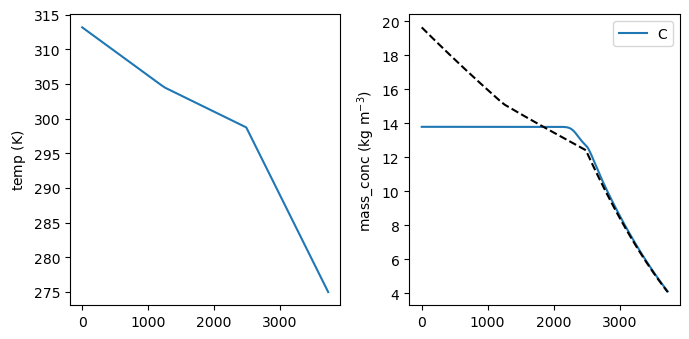

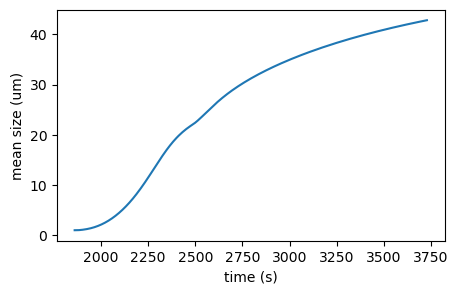

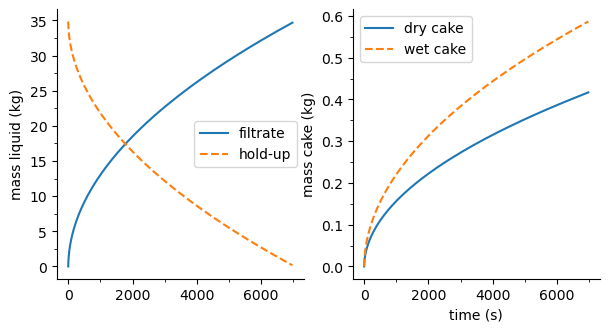

In [25]:
import matplotlib.pyplot as plt
from PharmaPy.Plotting import plot_function

fi, ax = plot_function(sim_opt.CR01, state_names=['temp', ('mass_conc', ('C', ))], figsize=(7, 3.5),
                        ncols=2)
ax[1].plot(sim_opt.CR01.result.time, sim_opt.CR01.result.solubility, '--k')
fi.tight_layout()

# Mean size constraint: CR01
moms = sim_opt.CR01.result.mu_n

fig, axis = plt.subplots(figsize=(5, 3))
axis.plot(sim_opt.CR01.result.time, moms[:, 1]/moms[:, 0] * 1e6)
axis.set_xlabel('time (s)')
axis.set_ylabel('mean size (um)')

# Production constraint: F01
sim_opt.F01.plot_profiles(figsize=(7, 3.5))

In [ ]:
BatchCryst()